In [1]:
from datasets import load_dataset

dataset =  load_dataset("JayalekshmiGopakumar/donutexample")

/home/accelex/anaconda3/envs/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/home/accelex/.cache/huggingface/datasets/JayalekshmiGopakumar___parquet/JayalekshmiGopakumar--donutexample-7c2f1d5e55226274/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 77.06it/s]


In [2]:
id2label=dataset["train"]['label']

Let's check out an example:

In [3]:
example = dataset['train'][0]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1025x1025>,
 'label': 'patents',
 'ground_truth': '{"gt_parse": {"class" : "patents"}}'}

As can be seen, we prepared the "ground_truth" key, which is a string-formatted dictionary containing a single `gt_parse` key.

In [4]:
example = dataset["train"][0]
example["ground_truth"]

'{"gt_parse": {"class" : "patents"}}'

One can use Python's `ast.literal_eval` function to turn the string into a Python dictionary. This helps verifying we have created the gt_parse string in the correct way:

In [5]:
from ast import literal_eval

literal_eval(example["ground_truth"])['gt_parse']

{'class': 'patents'}

In [6]:
from transformers import VisionEncoderDecoderConfig

max_length = 8
# image_size = [2560, 1920]
# let's use a smaller image size (height, width) because otherwise OOM
# the higher the resolution, the better the results will be
# so if you have a big GPU, feel free to increase
image_size = [1280, 960]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [7]:
'''from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)
model.save_pretrained("Donut/models")
processor.save_pretrained("Donut/models")'''

'from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig\n\nprocessor = DonutProcessor.from_pretrained("nielsr/donut-base")\nmodel = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)\nmodel.save_pretrained("Donut/models")\nprocessor.save_pretrained("Donut/models")'

In [8]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("Donut/models")
model = VisionEncoderDecoderModel.from_pretrained("Donut/models")


In [9]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/home/accelex/anaconda3/envs/venv/lib/python3.11/site-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


## Prepare dataset

The first thing we'll do is add the class names as added tokens to the vocabulary of the decoder of Donut, and the corresponding tokenizer.

This will result in a slight increase in performance, as otherwise a class might be split up into multiple subword tokens (e.g. the class "advertisement" might be split up into "adv", "ertisement"). It is beneficial to let the model just learn a single embedding vector for the token "advertisement".

In [10]:
len(processor.tokenizer)

57525

In [11]:
from typing import List

def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [12]:
additional_tokens = [
    "<patents/>",
    "<manuals/>",
    "<government_tenders/>",
    "<financial_reports/>",
    "<laws_and_regulations/>",
    "<scientific_articles/>"
]



add_tokens(additional_tokens)

In [13]:
processor.tokenizer.convert_tokens_to_ids(["<file_folder/>"])

[3]

In [14]:
len(processor.tokenizer)

57531

Next, we create a regular PyTorch Dataset. The class below returns `(pixel_values, labels)` pairs for each item of the dataset.

It's all we need for training the model!

In [15]:
import json
import random
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in additional_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]

        # pixel values (we remove the batch dimension)
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # labels, which are the input ids of the target sequence
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        
        encoding = dict(pixel_values=pixel_values,
                        labels=labels)
        
        return encoding

Let's create the dataset:

In [16]:
train_dataset = DonutDataset("JayalekshmiGopakumar/donutexample", max_length=max_length,
                             split="train", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, # rvlcdip dataset is preprocessed, so no need for this
                             )

Found cached dataset parquet (/home/accelex/.cache/huggingface/datasets/JayalekshmiGopakumar___parquet/JayalekshmiGopakumar--donutexample-7c2f1d5e55226274/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Let's check the first item of this dataset:

In [17]:
train_dataset[0]

{'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 'labels': tensor([57531, 57525, 57532,     2,  -100,  -100,  -100

In [18]:
from torch.utils.data import DataLoader

# I'm using a small batch size to make sure it fits in the memory Colab provides
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [19]:
train_dataloader

Let's check out the first batch:

In [20]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['pixel_values', 'labels'])


Let's check the labels:

In [21]:
for id in batch['labels'][0].tolist():
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_class>
<manuals/>
</s_class>
</s>
-100
-100
-100
-100


Let's visualize the pixel values by denormalizing:

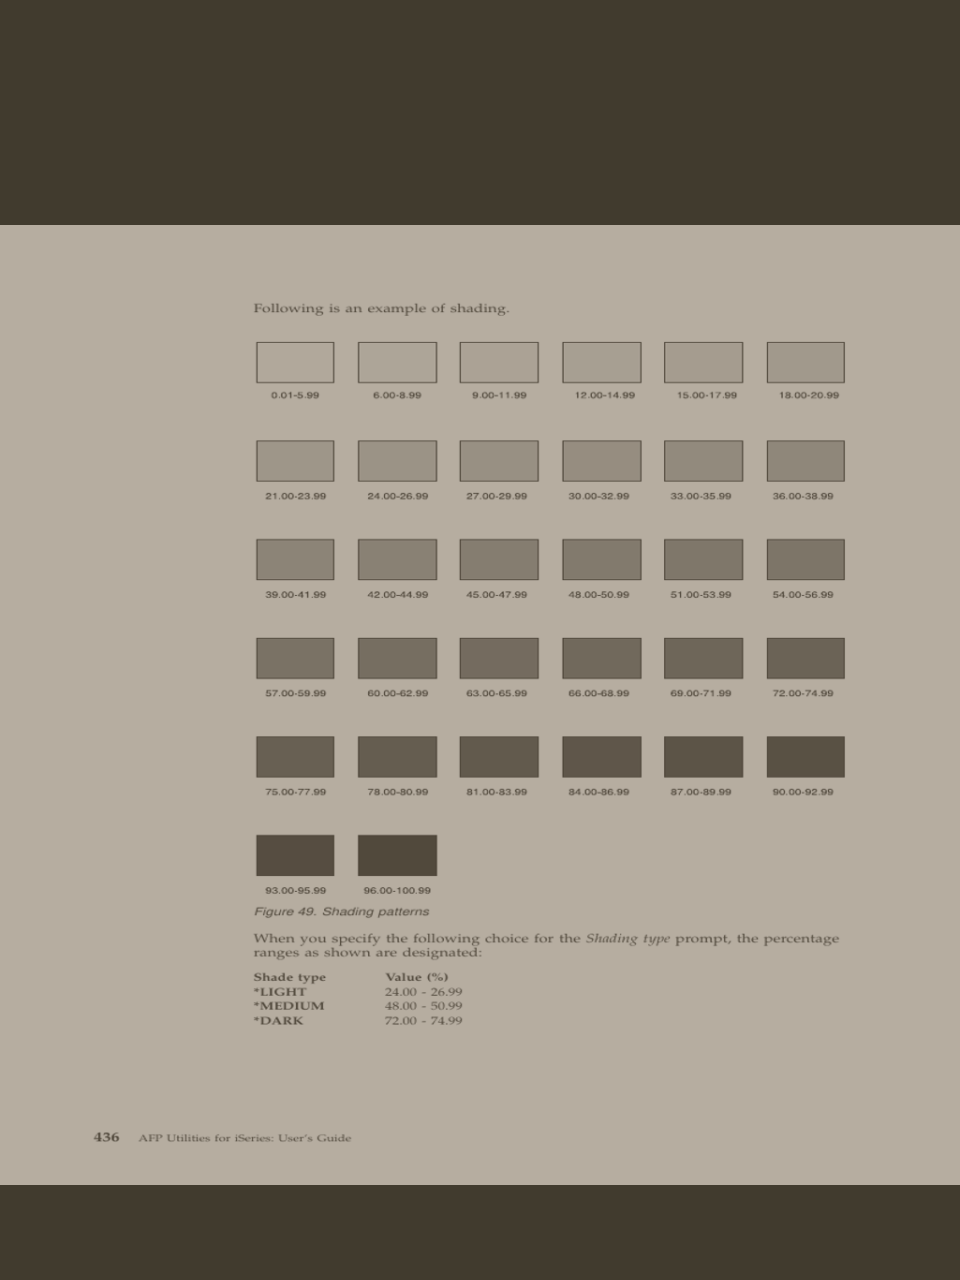

In [22]:
from PIL import Image
import numpy as np

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# unnormalize
reconstructed_image = (batch['pixel_values'][0] * torch.tensor(std)[:, None, None]) + torch.tensor(mean)[:, None, None]
# unrescale
reconstructed_image = reconstructed_image * 255
# convert to numpy of shape HWC
reconstructed_image = torch.moveaxis(reconstructed_image, 0, -1)
image = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
image

This indeed looks like an email. So data preparation seems ok!

In [23]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_rvlcdip>'])[0]

In [24]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_rvlcdip>


Let's train!

In [25]:
import torch
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

for epoch in range(10):
    print("Epoch:", epoch+1)
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = model(pixel_values=pixel_values,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print("Loss:", loss.item())

Epoch: 1


 17%|█▋        | 1/6 [00:15<01:18, 15.63s/it]

Loss: 16.37621307373047


: 

: 

In [ ]:
import re

model.eval()

dataset = load_dataset("nielsr/rvl_cdip_10_examples_per_class_donut", split="test")

output_list = []
accs = []
for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]
    score = float(seq["class"] == gt["class"])

    accs.append(score)

    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

In [ ]:
scores["mean_accuracy"]

That looks a lot better than random accuracy, suggesting that our model seems to learn well!